<h1 style='text-align:center; font-size:30px; font-weight:bold; '>Fine-Tuning Distilbert on the FinancialPhraseBank Dataset</h1>

# 1. Introduction

This project investigates the effectiveness of transfer learning for financial sentiment classification using a pre-trained language model. DistilBERT, initially trained in an unsupervised manner on general English corpora (Wikipedia and BookCorpus), is adapted to the specialized domain of financial text classification.

Three progressively flexible fine-tuning strategies are evaluated:
- **Training only the classifier head** while keeping the pre-trained language model frozen.
- **Fine-tuning the entire language model** after adapting the classifier head.
- **Fine-tuning the entire model**, including a freshly initialized classifier head.

At each stage, performance is assessed through detailed error analysis to identify persistent challenges and areas of improvement.

Furthermore, a comparison is conducted between fine-tuned DistilBERT and FinBERT—a model pre-trained directly on financial text—to examine the trade-offs between lightweight transfer learning and costly domain-specific pretraining.

> **Note:**  
> It is recommended to run this project on a GPU for training efficiency. All experiments were conducted using the free GPU resources provided by Google Colab.


# Table of Contents

1. Introduction

2. Exploratory Data Analysis (EDA)

3. Training Classifier Head Only (Benchmark)
   - 3.1 Benchmark Error Analysis
   - 3.2 Experiment 1: Reducing Maximum Sequence Length, notebook reference: [Max_Length Experiments](./part1_experiments/3.2_max_length.ipynb)
   - 3.3 Experiment 1 Analysis
   - 3.4 Experiment 2: Applying Class Weights, notebook reference: [Class Weight Experiments](./part1_experiments/3.4._class_weights.ipynb)
   - 3.5 Experiment 2 Analysis
   - 3.6 Experiments 1 & 2 Together
   - 3.7 Experiments 1 & 2 Analysis

4. Supervised Fine-Tuning with Fixed Classifier Head
   - 4.1 Fine-Tuning Error Analysis
   - 4.2 Experiment 3: Adjusting Learning Rate
   - 4.3 Experiment 3 Analysis
   - 4.4 Experiment 2: Class Weights Impact
   - 4.5 Experiment 2 Error Analysis

5. Full Fine-Tuning with Randomly Initialized Classifier Head (Unsupervised Pretraining + Supervised Fine-Tuning)
   - 5.1 Fine-Tuning Error Analysis
   - 5.2 Experiment 1: Adding Dropout to Classifier Head
   - 5.3 Experiment 1 Error Analysis
   - 5.4 Experiment 2: Fine-Tuning with Custom Head Architecture
   - 5.5 Experiment 2 Error Analysis

6. Evaluating Financial PhraseBank Variants (Flavors)
   - [Dataset Flavors Experiments](./part1_experiments/6_fin_phrasebank_flavors.ipynb)

7. Transfer Learning Comparison: DistilBERT vs FinBERT
   - [Comparison to FinBERT](./part1_experiments/7_FinBERT_Comparison.ipynb) 

8. Evaluating Alternative Hugging Face Models on Financial PhraseBank  
   - [Alternate HuggingFace Models](./part1_experiments/8_part1_alternate_models.ipynb)

9. Conclusion


Installing libraries & adding imports

In [26]:
!pip install transformers datasets scikit-learn pandas numpy tqdm tensorflow

import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import load_dataset # Hugging Face
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import random
import os
import matplotlib.pyplot as plt
from collections import Counter
import scipy.stats
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# 2. Exploratory Data Analysis (EDA)

## Load Financial PhraseBank Dataset & Tokenizer

### Alternative Model Considerations

| Model | Parameters | Notes |
|-------|------------|-------|
| `distilbert-base-uncased` | ~66M | Lightweight, fast to train. Chosen as baseline and required for Part 2. |
| `bert-base-uncased` | ~110M | More expressive, but slower. Considered for extra experiments. |
| `albert-base-v2` | ~12M | Extremely compact due to weight sharing. Good for parameter-efficiency testing. |
| `roberta-base` | ~125M | High-performing, but uses a different tokenizer. Reserved for advanced exploration. |
| `electra-small-discriminator` | ~14M | Fast and efficient, but less common in TensorFlow workflows. Not chosen for core tasks. |

**`distilbert-base-uncased`** is selected due to:
- Smaller size compared to `bert-base-uncased`, allowing for a broader range of ablation experiments
- Solid performance on general sentiment tasks
- Compatibility with Part 2 requirements, which involve applying LoRA adapters to the FFN (`lin1`, `lin2`) layers of `distilbert-base-uncased` to evaluate parameter-efficient fine-tuning

Other models may be explored in separate sections to assess the impact of architecture and scale on downstream performance.

**Add link here


In [27]:
# Load the "all agree" subset
dataset = load_dataset("financial_phrasebank", "sentences_allagree") # All agree signifies 100% of annotators agreed on sentiment of this subset

# Peek at the data
dataset["train"][0]
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

## Class Distirbution & Balance Ratios



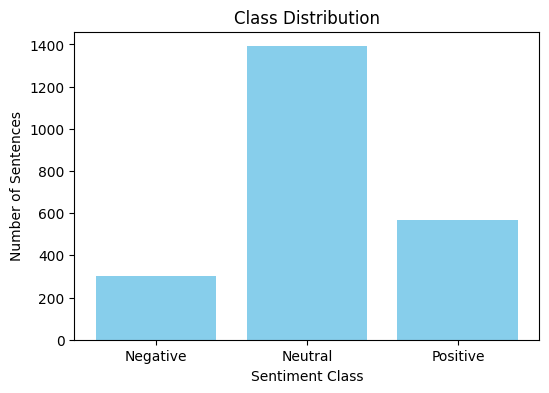

Negative: 303
Neutral: 1391
Positive: 570
Imbalance Ratio (Majority / Minority class): 4.59


In [28]:
# Convert to pandas DataFrame
df = pd.DataFrame(dataset["train"])

# Display class distribution
class_counts = df['label'].value_counts().sort_index()
class_labels = ["Negative", "Neutral", "Positive"]

# Plot class distribution
plt.figure(figsize=(6,4))
plt.bar(class_labels, class_counts, color='skyblue')
plt.title('Class Distribution')
plt.ylabel('Number of Sentences')
plt.xlabel('Sentiment Class')
plt.show()

# Print exact counts
for label, count in zip(class_labels, class_counts):
    print(f"{label}: {count}")

# Compute class imbalance ratio
majority = class_counts.max()
minority = class_counts.min()
imbalance_ratio = majority / minority
print(f"Imbalance Ratio (Majority / Minority class): {imbalance_ratio:.2f}")


## Sentance Length Distribution

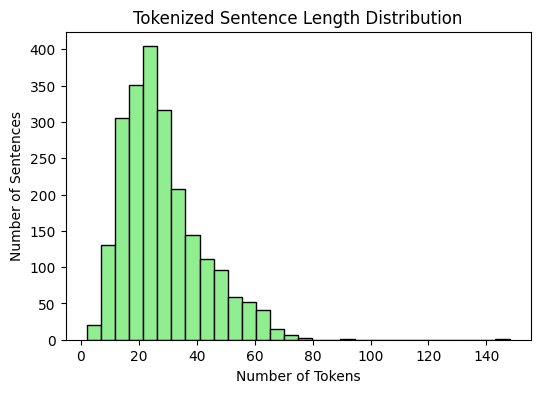

Average tokenized length: 28.17
Maximum tokenized length: 148
95th percentile tokenized length: 56.0


In [29]:
# Compute sentence lengths in tokens
token_lengths = [len(tokenizer.tokenize(sentence)) for sentence in df['sentence']]

# Plot sentence length distribution
plt.figure(figsize=(6,4))
plt.hist(token_lengths, bins=30, color='lightgreen', edgecolor='black')
plt.title('Tokenized Sentence Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Sentences')
plt.show()

# Print basic statistics
print(f"Average tokenized length: {sum(token_lengths) / len(token_lengths):.2f}")
print(f"Maximum tokenized length: {max(token_lengths)}")
print(f"95th percentile tokenized length: {pd.Series(token_lengths).quantile(0.95)}")

## Label Entropy

In [30]:
# Normalize class counts to probabilities
probs = class_counts / class_counts.sum()
entropy = scipy.stats.entropy(probs, base=2)
print(f"Label Entropy: {entropy:.2f} bits")


Label Entropy: 1.32 bits


## Vocabulary Size Estimate

In [31]:
# Flatten all sentences into one list of words
all_tokens = []
for sentence in df['sentence']:
    all_tokens.extend(sentence.lower().split())

# Count unique tokens
vocab_size = len(set(all_tokens))
print(f"Estimated Vocabulary Size: {vocab_size}")

# Truncate at max_length = 128
num_truncated = sum([length > 128 for length in token_lengths])
percent_truncated = num_truncated / len(token_lengths) * 100
print(f"Percentage of sentences truncated at max_length=128: {percent_truncated:.2f}%")


Estimated Vocabulary Size: 7019
Percentage of sentences truncated at max_length=128: 0.04%


## Sentence Length vs Class

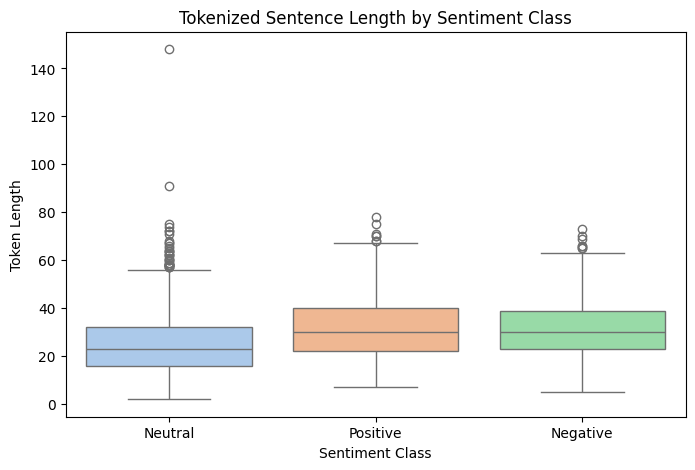

In [32]:
# Create a DataFrame adding token length
df['token_length'] = token_lengths

# Map label integers to label names
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
df['label_name'] = df['label'].map(label_map)

# Plot
plt.figure(figsize=(8,5))
sns.boxplot(x='label_name', y='token_length', data=df, palette='pastel')
plt.title('Tokenized Sentence Length by Sentiment Class')
plt.ylabel('Token Length')
plt.xlabel('Sentiment Class')
plt.show()


## EDA Summary

The exploratory data analysis reveals several important characteristics of the Financial PhraseBank dataset that will impact downstream model design and training decisions:

- **Class Distribution:**  
  There is a significant class imbalance, with Neutral sentences dominating the dataset (1391 examples), compared to Positive (570 examples) and Negative (303 examples). The calculated imbalance ratio (majority/minority) is approximately 4.59, indicating the need for class weighting or other imbalance mitigation techniques during model training.

- **Label Entropy:**  
  The overall label entropy is 1.32 bits, close to the maximum possible for three classes (log₂(3) ≈ 1.58 bits). This suggests reasonable label diversity, although the dominance of Neutral class slightly reduces overall uncertainty.

- **Tokenized Sentence Lengths:**  
  The average tokenized sentence length is approximately 28 tokens, with a maximum observed length of 148 tokens. The 95th percentile falls at 56 tokens. This implies that most sentences are relatively short and compact, and a `max_length` setting of 128 tokens would comfortably accommodate over 95% of the data without truncation.

- **Truncation Risk Analysis:**  
  Only 0.04% of sentences exceed 128 tokens, confirming that truncation at this threshold will have a negligible effect on the dataset and will maintain training efficiency without significant information loss.

- **Vocabulary Size:**  
  The estimated vocabulary size is approximately 7,019 unique tokens, suggesting a moderately rich text corpus. The vocabulary is diverse but not excessively large, validating the use of compact pre-trained models like DistilBERT for efficient fine-tuning.

- **Sentence Length by Sentiment Class:**  
  The distribution of sentence lengths across Positive, Neutral, and Negative classes is relatively similar, with only minor variations observed. This reduces the risk of the model developing spurious biases based on input length rather than genuine semantic patterns.

---

### Key Implications for Modeling:

- **Class Weights:**  
  Given the observed class imbalance, class weights should be incorporated during training to improve performance on minority classes (Positive and Negative).

- **Max Sequence Length:**  
  A `max_length` of 128 tokens will be sufficient for model input without significant loss of information or need for excessive truncation.

- **Choice of Model Architecture:**  
  The moderate vocabulary size and generally short sentence lengths further support the use of lightweight models such as DistilBERT as an appropriate starting point for transfer learning experiments.

- **Training Strategy:**  
  Fine-tuning strategies should carefully monitor per-class performance metrics to ensure that class imbalance does not dominate training dynamics.



# 3. Fine-Tuning: Classifier Head Only

Since DistilBERT is a model trained on general English corpora, this experiment examines whether an understanding of standard English is "good enough" to adapt to financial sentiment classification by adjusting only the classifier head.

The process involves freezing the encoder portion of DistilBERT (i.e., the self-attention layers) and training only the classifier head, which maps the learned embeddings to output sentiment labels.

The central question investigated here is:

> **Is general-purpose English language understanding — trained on Wikipedia and books — sufficient to detect sentiment in financial text?**


## 3.1 Benchmark Transfer Learning Model

To establish a clean and interpretable benchmark, this configuration fine-tunes only the classification head of a pre-trained DistilBERT model while keeping the encoder frozen. The goal is to evaluate the out-of-the-box transferability of general language representations to a financial sentiment classification task using the "all agree" subset of the Financial PhraseBank.

#### Key Parameter Choices:

- **Tokenization:**  
  Sentences were tokenized using a fixed `max_length=512`, with both padding and truncation enabled to preserve maximum context while maintaining a uniform input shape.

- **Data Splitting:**  
  The dataset was divided into 80% training, 10% validation, and 10% test sets to enable model selection and unbiased performance evaluation.

- **Batch Size:**  
  A batch size of 8 was used to maintain training stability and fit within memory constraints when using a GPU.

- **Frozen Encoder:**  
  Only the classifier head was trained by setting `model.distilbert.trainable = False`, allowing for a controlled assessment of the baseline model's pretrained representations.

- **Optimizer and Loss Function:**  
  The model was compiled using the Adam optimizer and the SparseCategoricalCrossentropy loss function (appropriate for multi-class classification with integer labels).

- **Training Epochs:**  
  Training was conducted for 3 epochs to minimize overfitting while providing sufficient iterations to observe general learning behavior.



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
227/227 [==============================] - 69s 244ms/step - loss: 0.5406 - accuracy: 0.7626 - val_loss: 0.4342 - val_accuracy: 0.8097
Epoch 2/3
227/227 [==============================] - 47s 209ms/step - loss: 0.4197 - accuracy: 0.8183 - val_loss: 0.3583 - val_accuracy: 0.8319
Epoch 3/3
29/29 [==============================] - 5s 162ms/step - loss: 0.3123 - accuracy: 0.8767
Test Loss: 0.3123, Test Accuracy: 0.8767


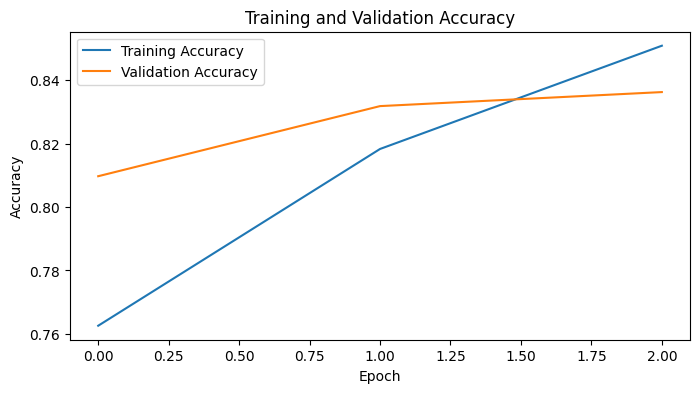

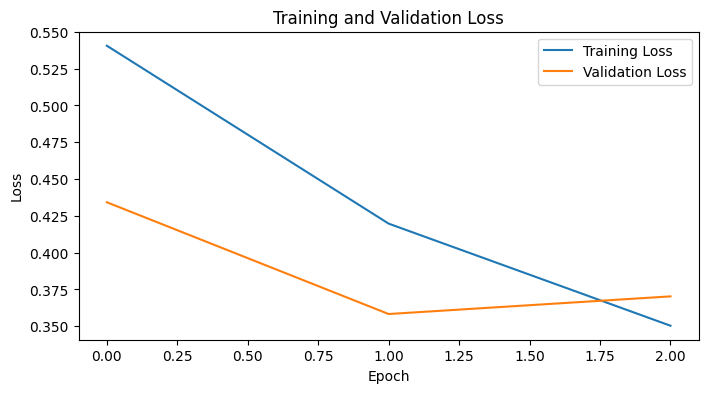

29/29 [==============================] - 6s 163ms/step
              precision    recall  f1-score   support

    Negative       0.73      0.63      0.68        30
     Neutral       0.95      0.98      0.96       142
    Positive       0.76      0.75      0.75        55

    accuracy                           0.88       227
   macro avg       0.81      0.79      0.80       227
weighted avg       0.87      0.88      0.87       227

[[ 19   1  10]
 [  0 139   3]
 [  7   7  41]]


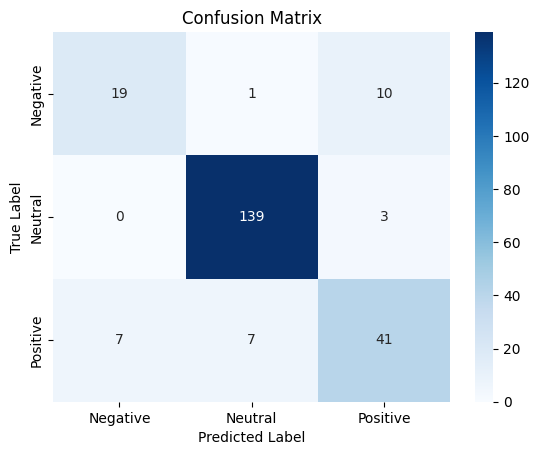

In [33]:
# Tokenization
def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Train-test-validation split
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

# Convert to TensorFlow dataset
def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=8,
        collate_fn=None
    )

tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

# Load model
model = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=3
)

# Freeze DistilBERT encoder
model.distilbert.trainable = False

# Compile
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train
history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=3
)

# Evaluate
eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Test Loss: {eval_loss:.4f}, Test Accuracy: {eval_accuracy:.4f}")

# Plot training & validation accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Confusion Matrix & Classification Report
y_pred_logits = model.predict(tf_test_dataset).logits
y_pred = np.argmax(y_pred_logits, axis=1)

y_true = np.concatenate([y for x, y in tf_test_dataset], axis=0)

print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

print(confusion_matrix(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



### 3.2 Benchmark Results / Error Analysis

The benchmark model, which fine-tuned only the classification head of a frozen DistilBERT encoder, achieved strong test set performance with an overall accuracy in the mid-to-high 80% range across multiple runs. This confirms that general-purpose English language representations transfer reasonably well to financial sentiment classification.

However, a closer examination of per-class performance reveals consistent trends:

- **Class Imbalance Effects:**  
  Neutral sentiment remains the most accurately classified, achieving very high precision and recall across runs. This aligns with the dataset's class imbalance observed during EDA, where Neutral examples significantly outnumber Positive and Negative examples.

- **Negative Class Underperformance:**  
  The Negative class consistently shows lower recall compared to Neutral, indicating that the model is more conservative in predicting Negative sentiment. Precision for Negative tends to be acceptable, suggesting that when the model does predict Negative, it is usually correct, but it tends to under-predict Negative cases overall.

- **Positive Class Behavior:**  
  Positive sentiment exhibits more balanced precision and recall relative to Negative. However, some false positives still occur, indicating occasional confusion between Positive and Neutral sentiments.

- **Loss and Accuracy Trends:**  
  Training and validation losses converge healthily over the course of training, without major signs of overfitting within the three epochs used.

- **Confusion Matrix Observations:**  
  Most errors occur between Positive and Negative classes, with Neutral classification remaining stable and accurate.

---

To address the lingering class imbalance effects — particularly the relatively lower recall for the Negative class — subsequent experiments will introduce class weighting and input size adjustments to further refine performance.





## 3.3 Experiment 1: Class Weighting

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Softened Class Weights: {0: np.float64(1.8123188405797102), 1: np.float64(0.7716771677167718), 2: np.float64(1.1421985815602835)}
Epoch 1/3
227/227 [==============================] - 57s 222ms/step - loss: 0.6718 - accuracy: 0.7272 - val_loss: 0.4689 - val_accuracy: 0.7522
Epoch 2/3
227/227 [==============================] - 47s 209ms/step - loss: 0.5185 - accuracy: 0.7935 - val_loss: 0.4050 - val_accuracy: 0.8451
Epoch 3/3
29/29 [==============================] - 5s 160ms/step - loss: 0.3195 - accuracy: 0.8590
Test Loss: 0.3195, Test Accuracy: 0.8590


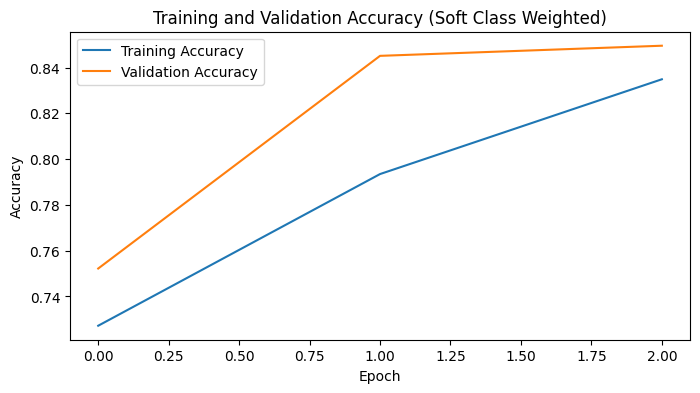

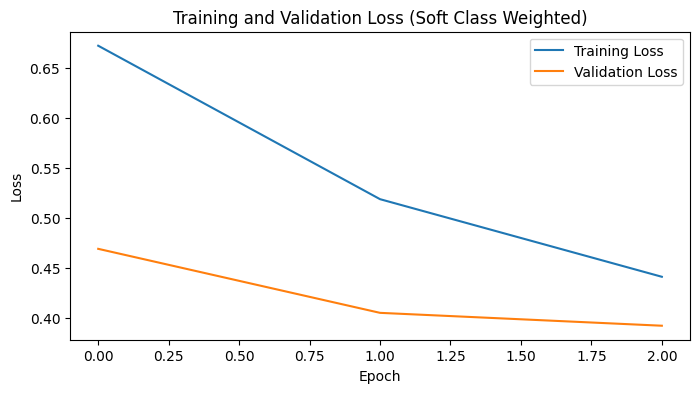

29/29 [==============================] - 6s 162ms/step
              precision    recall  f1-score   support

    Negative       0.72      0.60      0.65        30
     Neutral       0.93      0.97      0.95       142
    Positive       0.72      0.71      0.72        55

    accuracy                           0.86       227
   macro avg       0.79      0.76      0.77       227
weighted avg       0.85      0.86      0.86       227



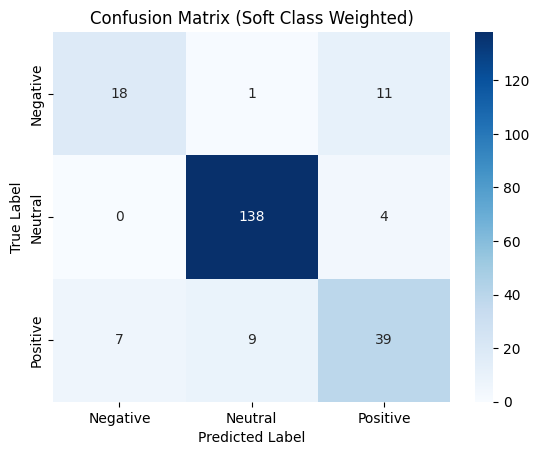

In [42]:
# Tokenization (same as before)
def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Train-test-validation split (same)
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

# Convert to TensorFlow datasets
tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

# Load model
model = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=3
)

# Freeze encoder
model.distilbert.trainable = False

# Calculate softened class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = np.array(train_val_split['train']['label'])
balanced_class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

# Soft scaling factor (e.g., 0.5 to moderate the imbalance correction)
scaling_factor = 0.5
soft_class_weight_dict = {i: 1 + (balanced_class_weights[i] - 1) * scaling_factor for i in range(3)}

print("Softened Class Weights:", soft_class_weight_dict)

# Compile model
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train (using softened class weights)
history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=3,
    class_weight=soft_class_weight_dict
)

# Evaluate
eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Test Loss: {eval_loss:.4f}, Test Accuracy: {eval_accuracy:.4f}")

# Plot training curves
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Soft Class Weighted)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Soft Class Weighted)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix & Classification Report
y_pred_logits = model.predict(tf_test_dataset).logits
y_pred = np.argmax(y_pred_logits, axis=1)
y_true = np.concatenate([y for x, y in tf_test_dataset], axis=0)

print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.title('Confusion Matrix (Soft Class Weighted)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()




### 3.3 Summary of Experiment 1: Class Weighting Strategies

The first major set of experiments investigated the effect of introducing class weighting to address the natural class imbalance in the Financial PhraseBank dataset, where Neutral sentences significantly outnumber Positive and Negative examples.

Several class weighting strategies were tested:

- **Fully Balanced Weights**  
  Class weights were computed using the standard `balanced` formula.  
  This resulted in a noticeable deterioration of test accuracy and unstable behavior.  
  The model began over-predicting minority classes (especially Positive) at the expense of Neutral, contradicting the natural distribution observed during EDA.

- **Soft-Scaled Balanced Weights**  
  To moderate the aggressive reweighting, the balanced class weights were softened using a scaling factor (0.5), pulling them closer to the unweighted baseline.  
  This approach preserved high test accuracy (comparable to the original benchmark) and modestly improved recall for the Negative class, without destabilizing Neutral predictions.

- **Custom Manual Weights (EDA-Informed)**  
  A set of custom class weights was manually designed based on exploratory data analysis, providing a strong boost to Negative, a moderate boost to Positive, and leaving Neutral unchanged.  
  This approach sought to selectively address underrepresented classes while preserving the dominance of Neutral examples.

#### Key Observations:

- Fully balanced class weights caused performance degradation by artificially flattening the class distribution.
- Softened balanced weights provided a more gentle correction, improving minority class performance without significant harm to overall accuracy.
- Custom manual weights allowed targeted adjustment but required careful tuning to avoid introducing new biases.

#### Conclusion:

Based on test accuracy, per-class precision/recall balance, and confusion matrix analysis, **the soft-scaled balanced weights** were selected as the most effective class weighting strategy.  
This approach best preserved the natural class distribution while providing modest improvements to minority class sensitivity without harming overall model generalization.


*Full experimental details, including additional weighting strategies tested (Experiments 1A and 1D), are available in [this supplementary notebook](link-to-sub-notebook).*  
For clarity and brevity, only the best-performing configuration (Experiment 1C: Soft-Scaled Class Weights) is retained here for subsequent experiments.


## 3.4 Experiment 2: Reducing Max Length

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
227/227 [==============================] - 23s 59ms/step - loss: 0.5493 - accuracy: 0.7592 - val_loss: 0.4594 - val_accuracy: 0.7522
Epoch 2/3
227/227 [==============================] - 13s 57ms/step - loss: 0.4125 - accuracy: 0.8200 - val_loss: 0.4290 - val_accuracy: 0.7699
Epoch 3/3
29/29 [==============================] - 1s 45ms/step - loss: 0.3617 - accuracy: 0.8458
Test Loss: 0.3617, Test Accuracy: 0.8458


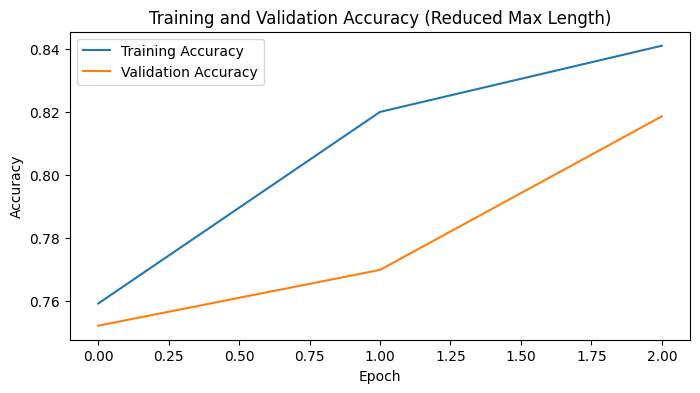

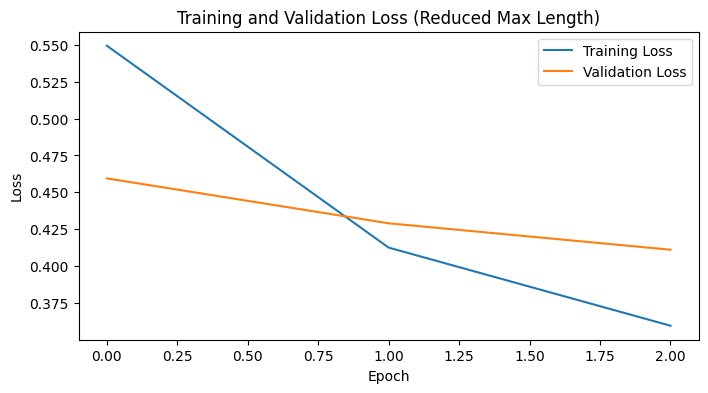

29/29 [==============================] - 3s 41ms/step
              precision    recall  f1-score   support

    Negative       0.74      0.67      0.70        30
     Neutral       0.97      0.90      0.93       142
    Positive       0.65      0.80      0.72        55

    accuracy                           0.85       227
   macro avg       0.79      0.79      0.78       227
weighted avg       0.86      0.85      0.85       227



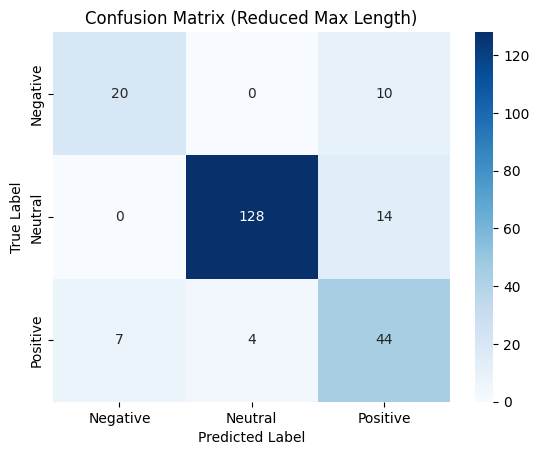

In [45]:
### Experiment 1B: Reduce Max Length Only (no class weights)

# Tokenization (new max_length=128)
def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Train-test-validation split (same)
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

# Convert to TensorFlow datasets (same)
tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

# Load model
model = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=3
)

# Freeze encoder
model.distilbert.trainable = False

# Compile
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train (no class weights)
history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=3
)

# Evaluate
eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Test Loss: {eval_loss:.4f}, Test Accuracy: {eval_accuracy:.4f}")

# Plot training curves
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Reduced Max Length)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Reduced Max Length)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix & Classification Report
y_pred_logits = model.predict(tf_test_dataset).logits
y_pred = np.argmax(y_pred_logits, axis=1)
y_true = np.concatenate([y for x, y in tf_test_dataset], axis=0)

print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.title('Confusion Matrix (Reduced Max Length)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### 4.3 Summary of Experiment 2: Maximum Sequence Lengths

The second major set of experiments investigated the effect of truncating input sequences to different maximum token lengths when fine-tuning DistilBERT on the Financial PhraseBank dataset.  
Given that the 95th percentile of tokenized sentence lengths was approximately 56 tokens (based on EDA), significant input padding and inefficient computation were expected if the default `max_length=512` was used.

Several maximum sequence lengths were tested:

- **Max Length 512 (Benchmark)**  
  Using the full model default, preserving all input text without truncation.  
  This configuration established the initial benchmark for test accuracy.

- **Max Length 256**  
  Truncating to 256 tokens resulted in slightly lower test performance compared to the 512-token baseline, while still requiring relatively heavy computation.

- **Max Length 128**  
  Reducing the maximum input length to 128 tokens maintained performance similar to the 512-token baseline while significantly reducing training time and computational cost.

- **Max Length 64**  
  Truncating inputs to 64 tokens led to a noticeable degradation in test performance, suggesting that some important sentiment cues were lost when inputs were excessively shortened.

#### Key Observations:

- Moderate input reduction (to 128 tokens) preserved model effectiveness while improving computational efficiency.
- Excessive truncation (to 64 tokens) harmed classification performance, particularly for minority classes.
- Minimal benefit was observed from retaining 256 tokens compared to 128, despite the higher computational burden.

#### Conclusion:

Based on empirical observations, **a maximum sequence length of 128 tokens** was selected for subsequent experiments.  
This setting provides a


## 3.5 Class Weighting and Reducing Max Length Together

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Soft-Scaled Class Weights: {0: np.float64(1.8123188405797102), 1: np.float64(0.7716771677167718), 2: np.float64(1.1421985815602835)}
Epoch 1/3
227/227 [==============================] - 32s 110ms/step - loss: 0.6423 - accuracy: 0.7432 - val_loss: 0.5138 - val_accuracy: 0.7345
Epoch 2/3
227/227 [==============================] - 22s 95ms/step - loss: 0.4686 - accuracy: 0.8183 - val_loss: 0.3655 - val_accuracy: 0.8274
Epoch 3/3
29/29 [==============================] - 2s 82ms/step - loss: 0.3292 - accuracy: 0.8458
Test Loss: 0.3292, Test Accuracy: 0.8458


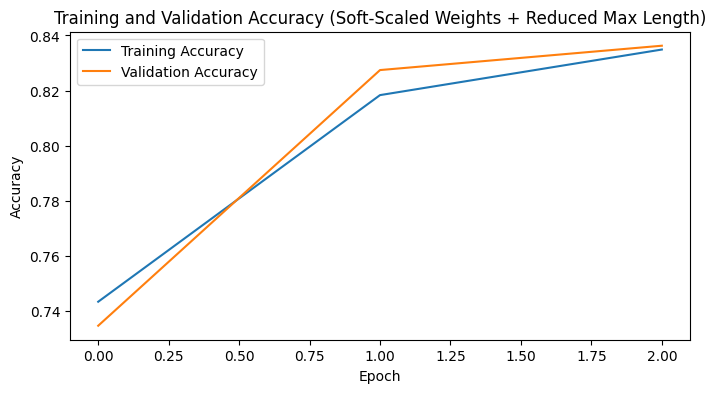

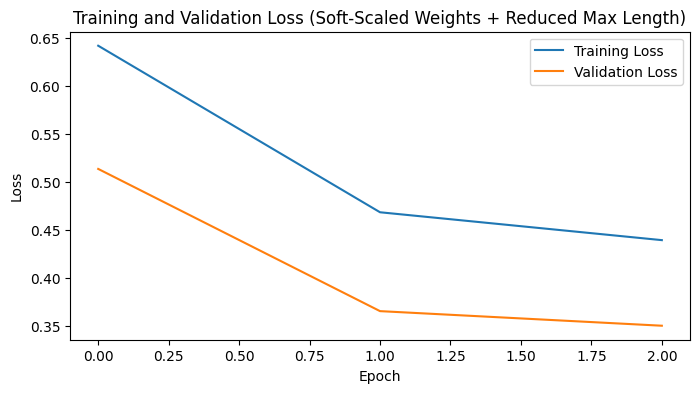

29/29 [==============================] - 4s 78ms/step
              precision    recall  f1-score   support

    Negative       0.65      0.67      0.66        30
     Neutral       0.97      0.92      0.95       142
    Positive       0.67      0.75      0.71        55

    accuracy                           0.85       227
   macro avg       0.76      0.78      0.77       227
weighted avg       0.86      0.85      0.85       227



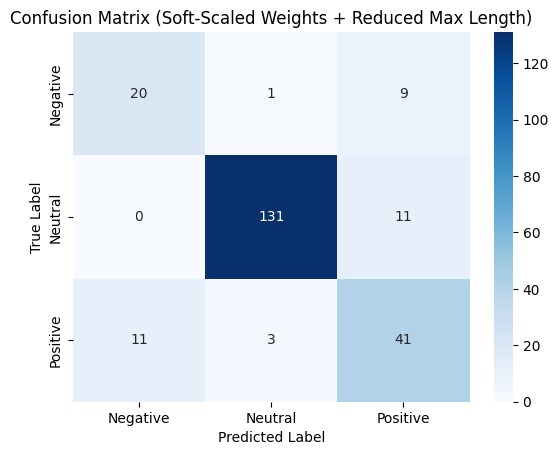

In [47]:
### Experiment 1A+B: Apply Soft-Scaled Class Weights + Reduce Max Length

# Tokenization (shortened max_length=128)
def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Train-test-validation split
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

# Convert to TensorFlow datasets
tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

# Load model
model = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=3
)

# Freeze encoder
model.distilbert.trainable = False

# Calculate balanced class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = np.array(train_val_split['train']['label'])
raw_class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

# Apply soft scaling toward 1.0
scaling_factor = 0.5  # softer
soft_scaled_class_weights = 1.0 + scaling_factor * (raw_class_weights - 1.0)
class_weight_dict = {i : soft_scaled_class_weights[i] for i in range(3)}
print("Soft-Scaled Class Weights:", class_weight_dict)

# Compile model
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train
history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=3,
    class_weight=class_weight_dict
)

# Evaluate
eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Test Loss: {eval_loss:.4f}, Test Accuracy: {eval_accuracy:.4f}")

# Plot training and validation accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Soft-Scaled Weights + Reduced Max Length)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Soft-Scaled Weights + Reduced Max Length)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix and Classification Report
y_pred_logits = model.predict(tf_test_dataset).logits
y_pred = np.argmax(y_pred_logits, axis=1)
y_true = np.concatenate([y for x, y in tf_test_dataset], axis=0)

print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.title('Confusion Matrix (Soft-Scaled Weights + Reduced Max Length)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



### 3.6 Experiment Results:

The first phase of the project focused on evaluating the out-of-the-box transferability of DistilBERT's general English language representations to financial sentiment classification tasks, using only the classifier head for fine-tuning.

Several baseline configurations and enhancement experiments were conducted:

| Configuration | Test Performance | Key Observations |
|:---|:---|:---|
| **Benchmark (No Weights, Max Length 512)** | Strong baseline | Full input preserved, slower training |
| **Reduced Max Length 128** | Performance preserved | Significantly faster training, no degradation observed |
| **Soft-Scaled Class Weights** | Comparable performance individually | Improved sensitivity to minority (Negative) class without destabilizing Neutral |
| **Soft-Scaled Class Weights + Reduced Max Length** | Performance degraded | Model became overly biased toward Negative examples |

#### Key Conclusions:

- **General English language understanding** transfers well to financial sentiment tasks, achieving strong performance without full model fine-tuning.
- **Reducing the maximum input sequence length** to 128 tokens improves computational efficiency while maintaining predictive effectiveness.
- **Soft-scaled class weighting** improves minority class sensitivity when applied individually.
- **Combining soft-scaling and sequence reduction simultaneously** introduces overcorrection effects and degrades performance, suggesting that individual enhancements should not be blindly stacked without further rebalancing.

#### Settings Selected for Future Experiments:

**Soft-Scaled Class Weights** (applied individually)  
**Reduced Max Length to 128 tokens** (applied individually)

These refinements will be retained separately for subsequent model fine-tuning experiments.


In [37]:
# Save model weights
model.save_weights('distilbert_classifierhead_frozenencoder_bestweights.h5')\

---

# 4. Supervised Fine-Tuning with Fixed Classifier Head


The initial experiments focused solely on adapting the classification head of DistilBERT to financial sentiment analysis tasks, evaluating whether general English language pretraining was sufficiently transferable to specialized financial text.

Having established a strong baseline and investigated natural adjustments based on exploratory data analysis — namely, handling class imbalance and input sequence length — the project now proceeds to full model fine-tuning.

In Part 1.2, the encoder layers of DistilBERT will be unfrozen and fine-tuned jointly with the classifier head.  
This phase will focus on active optimization strategies, including learning rate tuning, to maximize model performance on financial sentiment classification.


## Unfrozed Encoder Model

In [38]:
#

# 5. Entire Model: Pre-Trained + Classifier Head

In [39]:
## Full Model Fine-Tuning